In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE


In [2]:
# ==============================================================
# 📁 0️⃣ Create folder to save all plots
# ==============================================================
output_dir = "adaptivity_plots"
os.makedirs(output_dir, exist_ok=True)
print(f"✅ All plots will be saved in: {os.path.abspath(output_dir)}\n")


✅ All plots will be saved in: c:\Users\HP\Downloads\ML final\adaptivity_plots



In [3]:
# ==============================================================
# 1️⃣ Load the dataset
# ==============================================================
df = pd.read_csv("students_adaptability_level_online_education.csv")

print("=== Dataset Overview ===")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}\n")
df.head()


=== Dataset Overview ===
Rows: 1205, Columns: 14



,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,Moderate
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,Moderate
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Moderate
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,Low


### Preprocessing

In [4]:
# ==============================================================
# 2️⃣ Check for missing values
# ==============================================================
print("=== Missing Values Check ===")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "✅ No missing values found.\n")

=== Missing Values Check ===
✅ No missing values found.



In [5]:
# ==============================================================
# 3️⃣ Check for duplicates (do NOT remove them)
# ==============================================================
duplicates_count = df.duplicated().sum()
print(f"=== Duplicate Rows Check ===\nTotal Duplicates Found: {duplicates_count}")
if duplicates_count > 0:
    print("⚠️ Duplicates exist but will NOT be removed (kept for representation).")
print()

=== Duplicate Rows Check ===
Total Duplicates Found: 949
⚠️ Duplicates exist but will NOT be removed (kept for representation).



In [6]:
# ==============================================================
# 4️⃣ Outlier Detection (numeric columns)
# ==============================================================
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols:
    print("=== Outlier Detection (IQR method) ===")
    for col in numeric_cols:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        print(f"{col}: {len(outliers)} outliers")
else:
    print("✅ No numeric columns available for outlier detection.")
print()


✅ No numeric columns available for outlier detection.



In [7]:
# ==============================================================
# 5️⃣ Hybrid Encoding: Ordinal + Label Encoding
# ==============================================================
df_encoded = df.copy()

ordinal_mappings = {
    'Age': ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30'],
    'Education Level': ['School', 'College', 'University'],
    'Load-shedding': ['Low', 'High'],
    'Financial Condition': ['Poor', 'Mid', 'Rich'],
    'Network Type': ['2G', '3G', '4G'],
    'Class Duration': ['0', '1-3', '3-6'],
    'Adaptivity Level': ['Low', 'Moderate', 'High']  # Target
}

ordinal_features = list(ordinal_mappings.keys())
nominal_features = [col for col in df.columns if col not in ordinal_features]

# Apply Ordinal Encoding
ordinal_encoder = OrdinalEncoder(categories=[ordinal_mappings[col] for col in ordinal_features])
df_encoded[ordinal_features] = ordinal_encoder.fit_transform(df_encoded[ordinal_features])

# Apply Label Encoding for Nominal Features
label_encoders = {}
encoding_mappings = {}
for col in nominal_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
    encoding_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Record ordinal mappings
for col in ordinal_mappings:
    encoding_mappings[col] = {cat: i for i, cat in enumerate(ordinal_mappings[col])}

print("✅ Hybrid Encoding Complete.\n")

# 1️⃣ Show the encoding mappings for all columns
print("🔹 Encoding Mappings:\n")
for col, mapping in encoding_mappings.items():
    print(f"{col}: {mapping}")
    print("-" * 50)



✅ Hybrid Encoding Complete.

🔹 Encoding Mappings:

Gender: {'Boy': np.int64(0), 'Girl': np.int64(1)}
--------------------------------------------------
Institution Type: {'Government': np.int64(0), 'Non Government': np.int64(1)}
--------------------------------------------------
IT Student: {'No': np.int64(0), 'Yes': np.int64(1)}
--------------------------------------------------
Location: {'No': np.int64(0), 'Yes': np.int64(1)}
--------------------------------------------------
Internet Type: {'Mobile Data': np.int64(0), 'Wifi': np.int64(1)}
--------------------------------------------------
Self Lms: {'No': np.int64(0), 'Yes': np.int64(1)}
--------------------------------------------------
Device: {'Computer': np.int64(0), 'Mobile': np.int64(1), 'Tab': np.int64(2)}
--------------------------------------------------
Age: {'1-5': 0, '6-10': 1, '11-15': 2, '16-20': 3, '21-25': 4, '26-30': 5}
--------------------------------------------------
Education Level: {'School': 0, 'College': 1, 

In [8]:
# ==============================================================
# 6️⃣ Split into Training and Testing Sets
# ==============================================================
X = df_encoded.drop(columns=['Adaptivity Level'])
y = df_encoded['Adaptivity Level']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n✅ Data split into training and test sets.")
print(f"Training set: {X_train.shape[0]} rows")
print(f"Testing set: {X_test.shape[0]} rows\n")



✅ Data split into training and test sets.
Training set: 964 rows
Testing set: 241 rows



In [9]:
# ==============================================================
# Helper: decode adaptivity numeric -> label for readable plots
# ==============================================================
adaptivity_labels = ordinal_mappings['Adaptivity Level']  # ['Low','Moderate','High']
# y_train currently encoded as 0/1/2 matching ordinal mapping order
y_train_readable = y_train.map({i: label for i, label in enumerate(adaptivity_labels)})


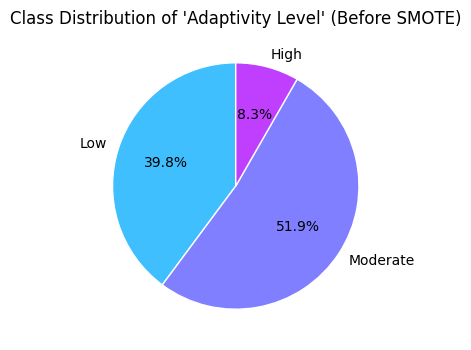

=== Class Distribution Before SMOTE ===
Adaptivity Level
Moderate    500
Low         384
High         80
Name: count, dtype: int64

⚠️ The pie chart showing class imbalance saved as 'adaptivity_plots\class_distribution_before_smote.png'



In [10]:
# ==============================================================
# 🔹 Visualizing Class Imbalance (Before SMOTE) — show & save
# ==============================================================
plt.figure(figsize=(4, 4))
counts = y_train_readable.value_counts().reindex(adaptivity_labels)  # ensure order Low, Moderate, High
colors = sns.color_palette("cool", n_colors=len(counts))
counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    labels=counts.index,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Class Distribution of 'Adaptivity Level' (Before SMOTE)")
plt.ylabel("")
fname = os.path.join(output_dir, "class_distribution_before_smote.png")
plt.savefig(fname, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

print("=== Class Distribution Before SMOTE ===")
print(y_train_readable.value_counts())
print(f"\n⚠️ The pie chart showing class imbalance saved as '{fname}'\n")


### Explanotory Data Analysis

In [11]:
# ==============================================================
# 7️⃣ EDA on Original (Unbalanced) Training Data
# ==============================================================
train_df = X_train.copy()
train_df['Adaptivity Level'] = y_train

# Decode labels for interpretability
decoded_df = train_df.copy()
for col, le in label_encoders.items():
    # only decode cols that exist in decoded_df
    if col in decoded_df.columns:
        decoded_df[col] = le.inverse_transform(decoded_df[col].astype(int))
for col, mapping in ordinal_mappings.items():
    if col in decoded_df.columns:
        decoded_df[col] = decoded_df[col].map({i: cat for i, cat in enumerate(mapping)})


=== Univariate Analysis ===



C:\Users\HP\AppData\Local\Temp\ipykernel_25204\4233199666.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=decoded_df, x=col, palette="cool")


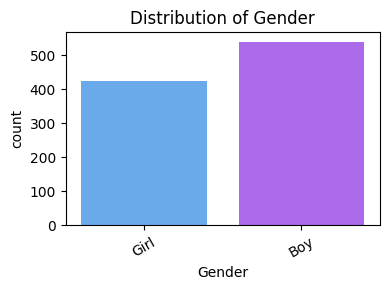

Gender Value Distribution (%):
Gender
Boy     56.02
Girl    43.98
Name: proportion, dtype: float64
------------------------------------------------------------


C:\Users\HP\AppData\Local\Temp\ipykernel_25204\4233199666.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=decoded_df, x=col, palette="cool")


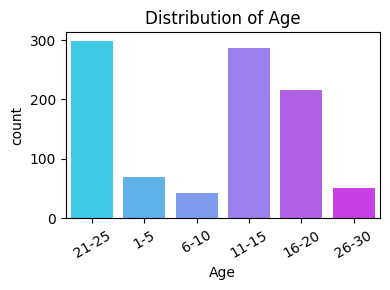

Age Value Distribution (%):
Age
21-25    30.91
11-15    29.77
16-20    22.41
1-5       7.16
26-30     5.39
6-10      4.36
Name: proportion, dtype: float64
------------------------------------------------------------


C:\Users\HP\AppData\Local\Temp\ipykernel_25204\4233199666.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=decoded_df, x=col, palette="cool")


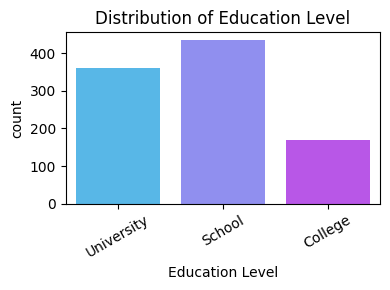

Education Level Value Distribution (%):
Education Level
School        45.02
University    37.55
College       17.43
Name: proportion, dtype: float64
------------------------------------------------------------


C:\Users\HP\AppData\Local\Temp\ipykernel_25204\4233199666.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=decoded_df, x=col, palette="cool")


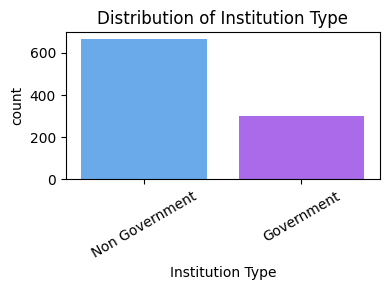

Institution Type Value Distribution (%):
Institution Type
Non Government    68.88
Government        31.12
Name: proportion, dtype: float64
------------------------------------------------------------


C:\Users\HP\AppData\Local\Temp\ipykernel_25204\4233199666.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=decoded_df, x=col, palette="cool")


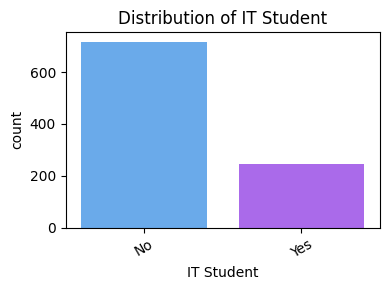

C:\Users\HP\AppData\Local\Temp\ipykernel_25204\4233199666.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=decoded_df, x=col, palette="cool")


IT Student Value Distribution (%):
IT Student
No     74.48
Yes    25.52
Name: proportion, dtype: float64
------------------------------------------------------------


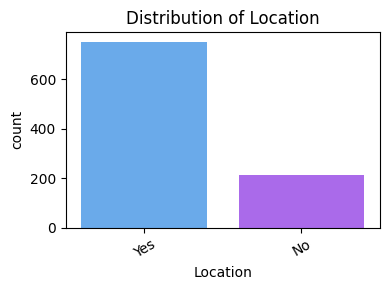

Location Value Distribution (%):
Location
Yes    77.9
No     22.1
Name: proportion, dtype: float64
------------------------------------------------------------


C:\Users\HP\AppData\Local\Temp\ipykernel_25204\4233199666.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=decoded_df, x=col, palette="cool")


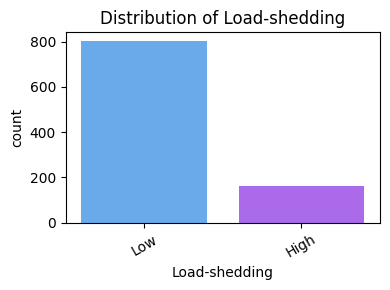

Load-shedding Value Distribution (%):
Load-shedding
Low     83.09
High    16.91
Name: proportion, dtype: float64
------------------------------------------------------------


C:\Users\HP\AppData\Local\Temp\ipykernel_25204\4233199666.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=decoded_df, x=col, palette="cool")


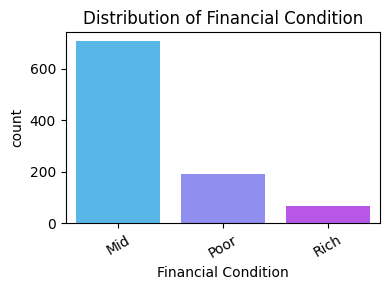

Financial Condition Value Distribution (%):
Financial Condition
Mid     73.13
Poor    19.81
Rich     7.05
Name: proportion, dtype: float64
------------------------------------------------------------


C:\Users\HP\AppData\Local\Temp\ipykernel_25204\4233199666.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=decoded_df, x=col, palette="cool")


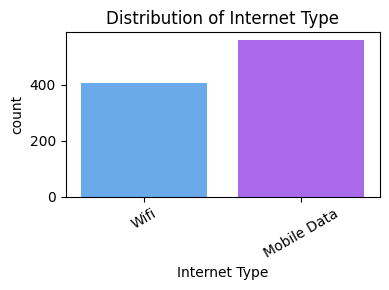

Internet Type Value Distribution (%):
Internet Type
Mobile Data    57.99
Wifi           42.01
Name: proportion, dtype: float64
------------------------------------------------------------


C:\Users\HP\AppData\Local\Temp\ipykernel_25204\4233199666.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=decoded_df, x=col, palette="cool")


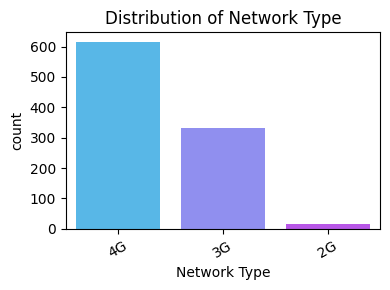

Network Type Value Distribution (%):
Network Type
4G    63.90
3G    34.54
2G     1.56
Name: proportion, dtype: float64
------------------------------------------------------------


C:\Users\HP\AppData\Local\Temp\ipykernel_25204\4233199666.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=decoded_df, x=col, palette="cool")


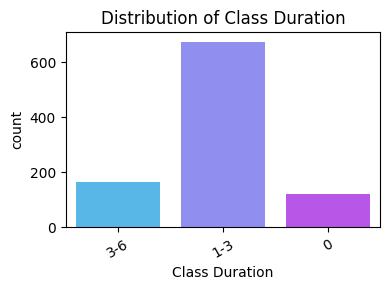

Class Duration Value Distribution (%):
Class Duration
1-3    70.02
3-6    17.22
0      12.76
Name: proportion, dtype: float64
------------------------------------------------------------


C:\Users\HP\AppData\Local\Temp\ipykernel_25204\4233199666.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=decoded_df, x=col, palette="cool")


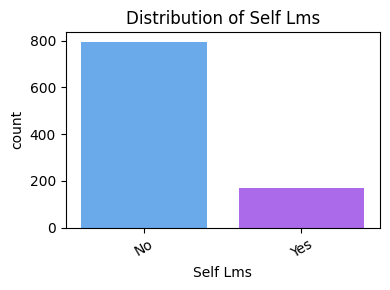

Self Lms Value Distribution (%):
Self Lms
No     82.57
Yes    17.43
Name: proportion, dtype: float64
------------------------------------------------------------


C:\Users\HP\AppData\Local\Temp\ipykernel_25204\4233199666.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=decoded_df, x=col, palette="cool")


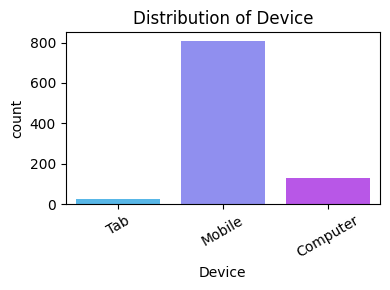

Device Value Distribution (%):
Device
Mobile      84.02
Computer    13.38
Tab          2.59
Name: proportion, dtype: float64
------------------------------------------------------------

=== Summary of Categorical Features ===
            Feature  Unique Values  Most Frequent
             Gender              2            Boy
                Age              6          21-25
    Education Level              3         School
   Institution Type              2 Non Government
         IT Student              2             No
           Location              2            Yes
      Load-shedding              2            Low
Financial Condition              3            Mid
      Internet Type              2    Mobile Data
       Network Type              3             4G
     Class Duration              3            1-3
           Self Lms              2             No
             Device              3         Mobile

✅ Univariate Analysis Completed. Summary saved to 'adaptivity_plots\cate

In [12]:
# ==============================================================
# 🔹 UNIVARIATE ANALYSIS (show & save)
# ==============================================================
print("=== Univariate Analysis ===\n")
categorical_features = [col for col in decoded_df.columns if col != 'Adaptivity Level']

for col in categorical_features:
    plt.figure(figsize=(4, 3))
    ax = sns.countplot(data=decoded_df, x=col, palette="cool")
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=30)
    plt.tight_layout()
    fname = os.path.join(output_dir, f"univariate_{col.replace(' ', '_')}.png")
    plt.savefig(fname, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()
    # print relative distribution to console
    value_counts = decoded_df[col].value_counts(normalize=True) * 100
    print(f"{col} Value Distribution (%):")
    print(value_counts.round(2))
    print("-" * 60)

# Summary Table (save to CSV)
summary_table = pd.DataFrame({
    "Feature": categorical_features,
    "Unique Values": [decoded_df[col].nunique() for col in categorical_features],
    "Most Frequent": [decoded_df[col].mode()[0] for col in categorical_features]
})
summary_csv = os.path.join(output_dir, "categorical_summary_table.csv")
summary_table.to_csv(summary_csv, index=False)
print("\n=== Summary of Categorical Features ===")
print(summary_table.to_string(index=False))
print(f"\n✅ Univariate Analysis Completed. Summary saved to '{summary_csv}'\n")

=== Feature Associations with Target (Adaptivity Level) ===



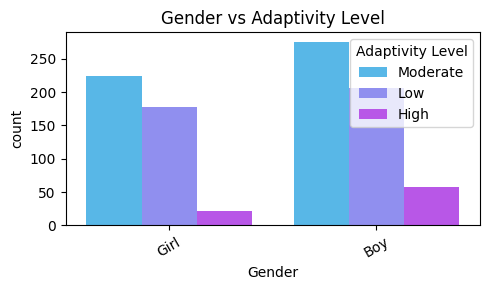

Gender vs Adaptivity Level: p-value = 0.0073
➡ Significant association (p < 0.05)



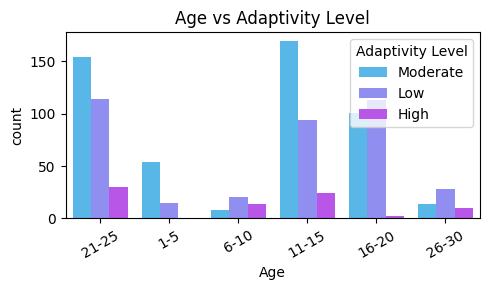

Age vs Adaptivity Level: p-value = 0.0000
➡ Significant association (p < 0.05)



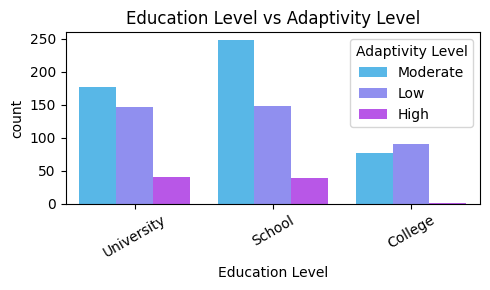

Education Level vs Adaptivity Level: p-value = 0.0000
➡ Significant association (p < 0.05)



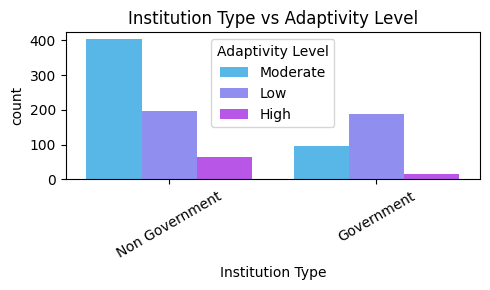

Institution Type vs Adaptivity Level: p-value = 0.0000
➡ Significant association (p < 0.05)



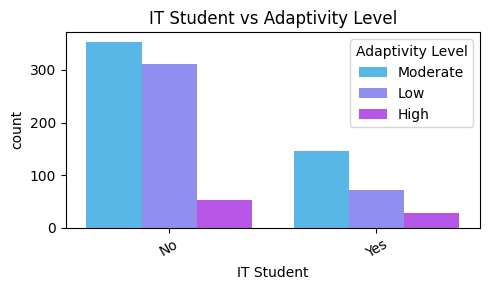

IT Student vs Adaptivity Level: p-value = 0.0002
➡ Significant association (p < 0.05)



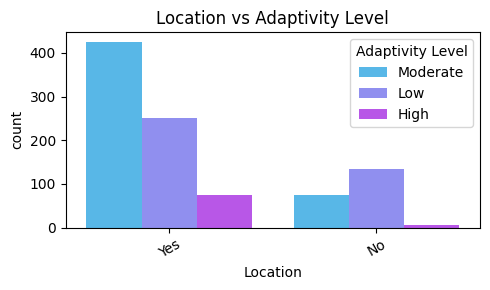

Location vs Adaptivity Level: p-value = 0.0000
➡ Significant association (p < 0.05)



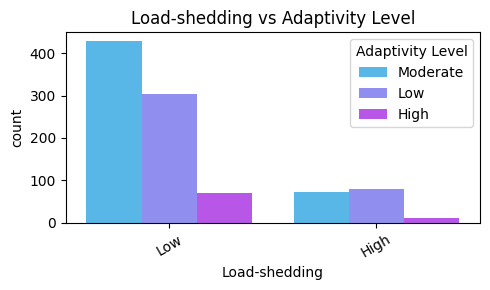

Load-shedding vs Adaptivity Level: p-value = 0.0299
➡ Significant association (p < 0.05)



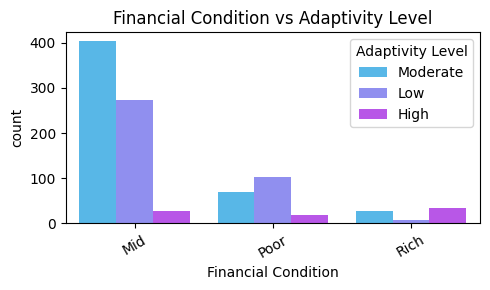

Financial Condition vs Adaptivity Level: p-value = 0.0000
➡ Significant association (p < 0.05)



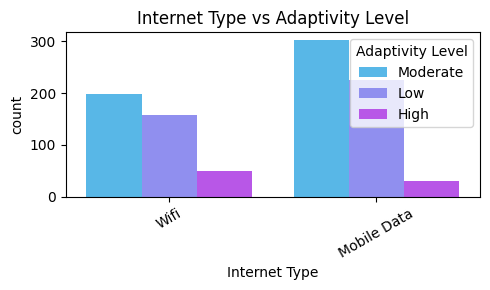

Internet Type vs Adaptivity Level: p-value = 0.0012
➡ Significant association (p < 0.05)



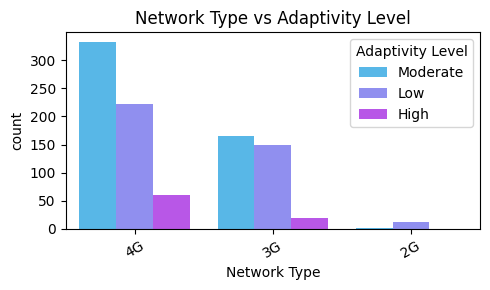

Network Type vs Adaptivity Level: p-value = 0.0001
➡ Significant association (p < 0.05)



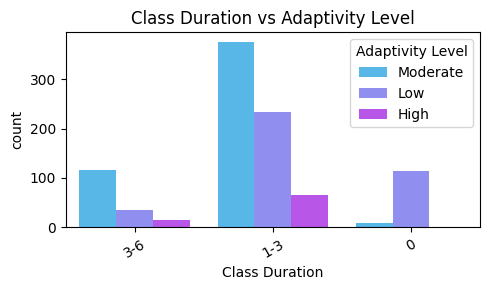

Class Duration vs Adaptivity Level: p-value = 0.0000
➡ Significant association (p < 0.05)



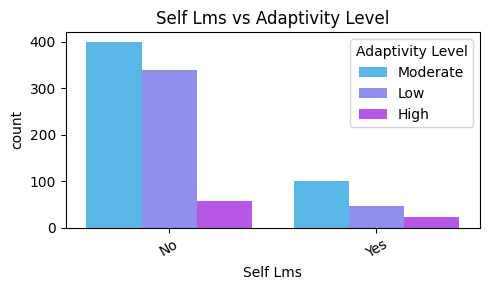

Self Lms vs Adaptivity Level: p-value = 0.0004
➡ Significant association (p < 0.05)



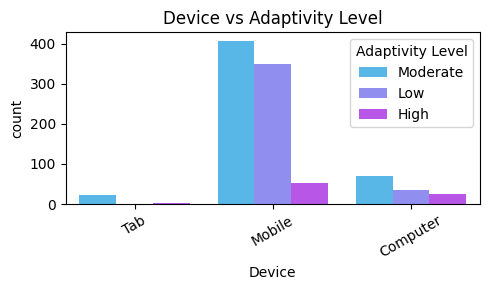

Device vs Adaptivity Level: p-value = 0.0000
➡ Significant association (p < 0.05)



In [13]:
# ==============================================================
# 🔸 BIVARIATE ANALYSIS (Feature vs Target) — show & save
# ==============================================================
print("=== Feature Associations with Target (Adaptivity Level) ===\n")
for col in categorical_features:
    plt.figure(figsize=(5, 3))
    ax = sns.countplot(data=decoded_df, x=col, hue='Adaptivity Level', palette="cool")
    plt.title(f"{col} vs Adaptivity Level")
    plt.xticks(rotation=30)
    plt.tight_layout()
    fname = os.path.join(output_dir, f"bivariate_{col.replace(' ', '_')}_vs_adaptivity.png")
    plt.savefig(fname, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

    # Chi-square test
    contingency = pd.crosstab(decoded_df[col], decoded_df['Adaptivity Level'])
    chi2, p, dof, _ = chi2_contingency(contingency)
    print(f"{col} vs Adaptivity Level: p-value = {p:.4f}")
    if p < 0.05:
        print("➡ Significant association (p < 0.05)\n")
    else:
        print("No significant association\n")



=== Feature Associations with Target (Adaptivity Level) ===



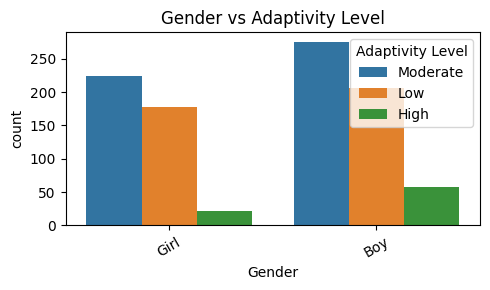

Chi-square test for Gender vs Adaptivity Level: p-value = 0.0073
➡ Significant association (p < 0.05)



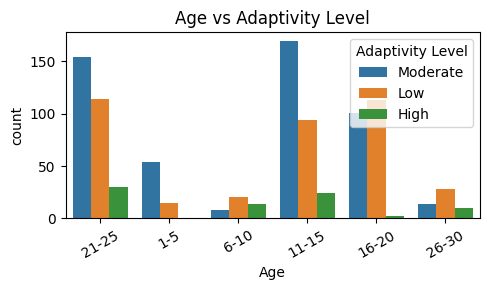

Chi-square test for Age vs Adaptivity Level: p-value = 0.0000
➡ Significant association (p < 0.05)



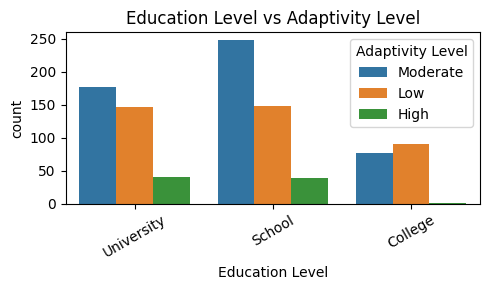

Chi-square test for Education Level vs Adaptivity Level: p-value = 0.0000
➡ Significant association (p < 0.05)



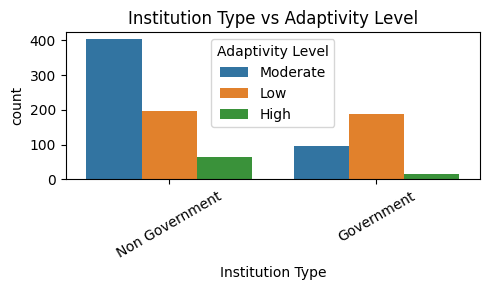

Chi-square test for Institution Type vs Adaptivity Level: p-value = 0.0000
➡ Significant association (p < 0.05)



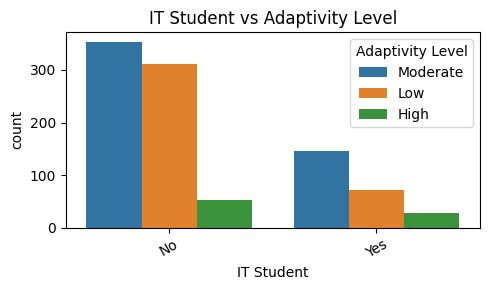

Chi-square test for IT Student vs Adaptivity Level: p-value = 0.0002
➡ Significant association (p < 0.05)



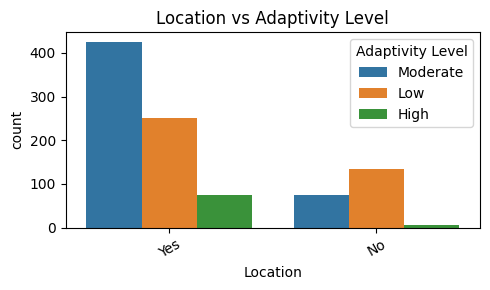

Chi-square test for Location vs Adaptivity Level: p-value = 0.0000
➡ Significant association (p < 0.05)



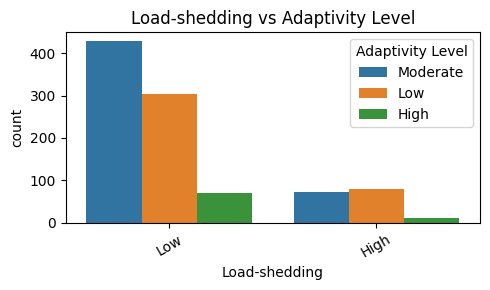

Chi-square test for Load-shedding vs Adaptivity Level: p-value = 0.0299
➡ Significant association (p < 0.05)



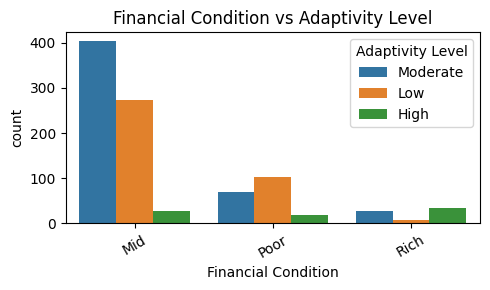

Chi-square test for Financial Condition vs Adaptivity Level: p-value = 0.0000
➡ Significant association (p < 0.05)



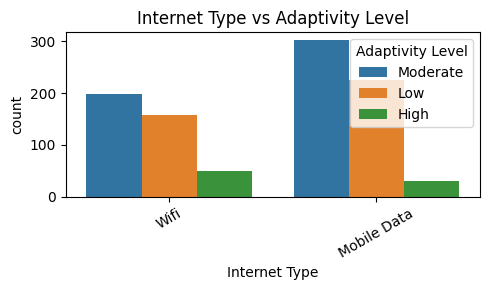

Chi-square test for Internet Type vs Adaptivity Level: p-value = 0.0012
➡ Significant association (p < 0.05)



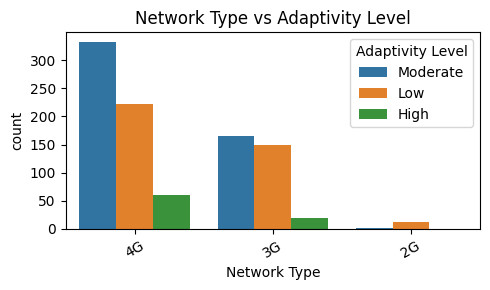

Chi-square test for Network Type vs Adaptivity Level: p-value = 0.0001
➡ Significant association (p < 0.05)



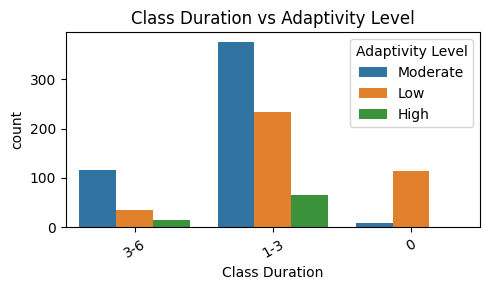

Chi-square test for Class Duration vs Adaptivity Level: p-value = 0.0000
➡ Significant association (p < 0.05)



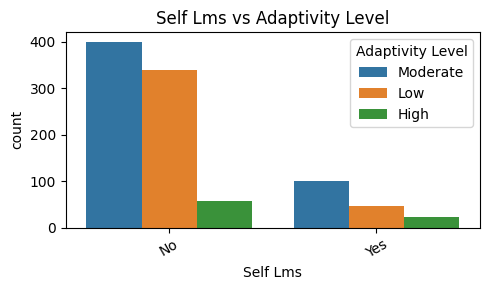

Chi-square test for Self Lms vs Adaptivity Level: p-value = 0.0004
➡ Significant association (p < 0.05)



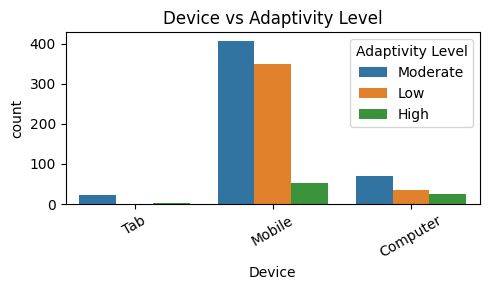

Chi-square test for Device vs Adaptivity Level: p-value = 0.0000
➡ Significant association (p < 0.05)



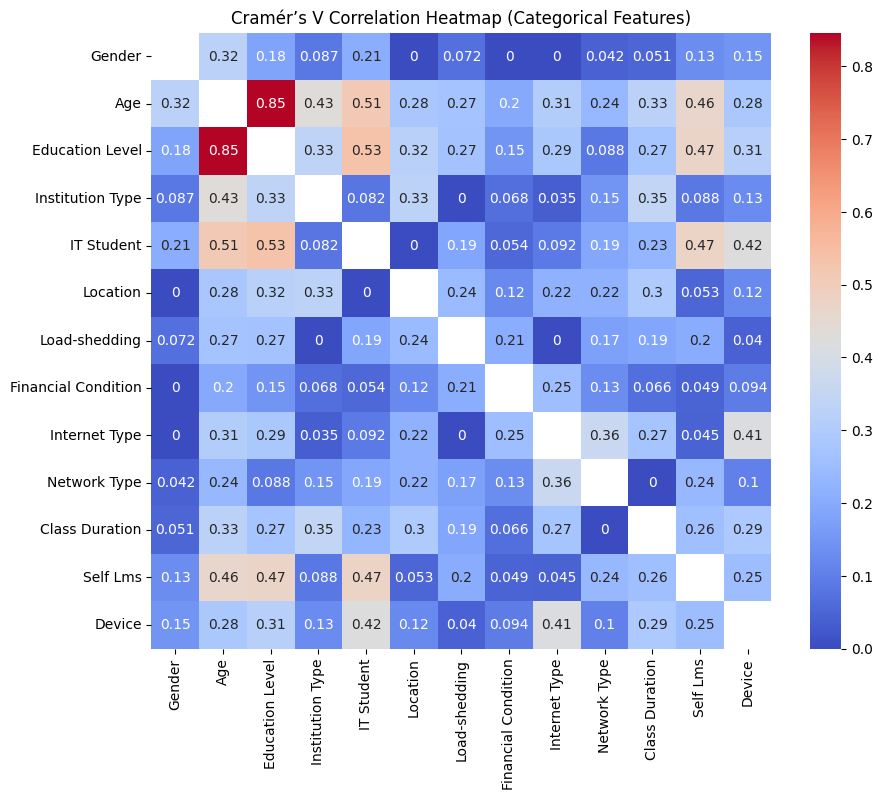

=== Pairwise Feature Relationships (Chi-square Tests) ===

Gender ↔ Age : Significant association (p=0.0000)
Gender ↔ Education Level : Significant association (p=0.0000)
Gender ↔ Institution Type : Significant association (p=0.0042)
Gender ↔ IT Student : Significant association (p=0.0000)
Gender ↔ Load-shedding : Significant association (p=0.0140)
Gender ↔ Self Lms : Significant association (p=0.0000)
Gender ↔ Device : Significant association (p=0.0000)
Age ↔ Education Level : Significant association (p=0.0000)
Age ↔ Institution Type : Significant association (p=0.0000)
Age ↔ IT Student : Significant association (p=0.0000)
Age ↔ Location : Significant association (p=0.0000)
Age ↔ Load-shedding : Significant association (p=0.0000)
Age ↔ Financial Condition : Significant association (p=0.0000)
Age ↔ Internet Type : Significant association (p=0.0000)
Age ↔ Network Type : Significant association (p=0.0000)
Age ↔ Class Duration : Significant association (p=0.0000)
Age ↔ Self Lms : Signific

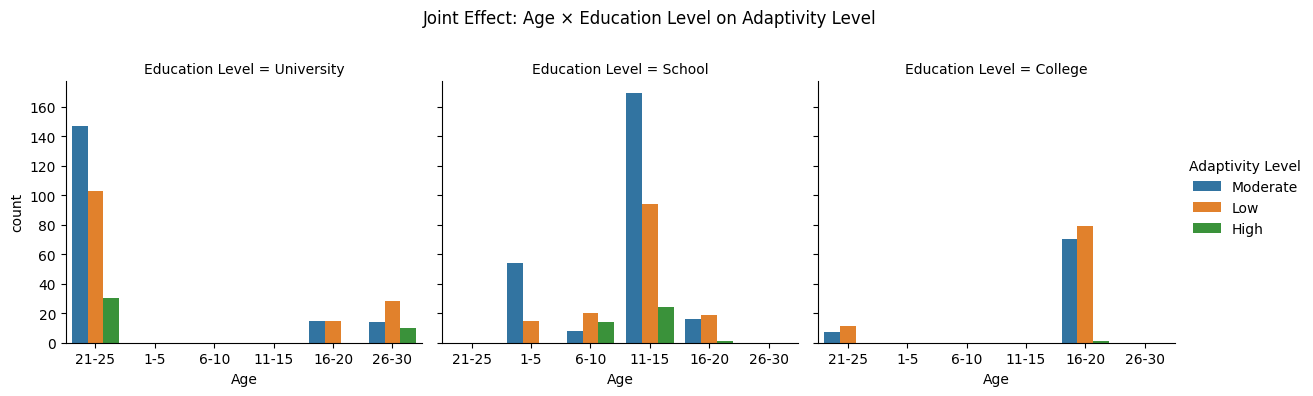

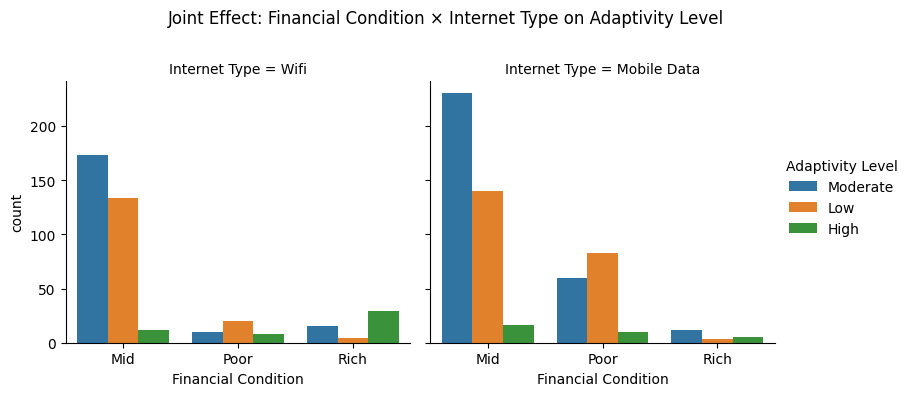

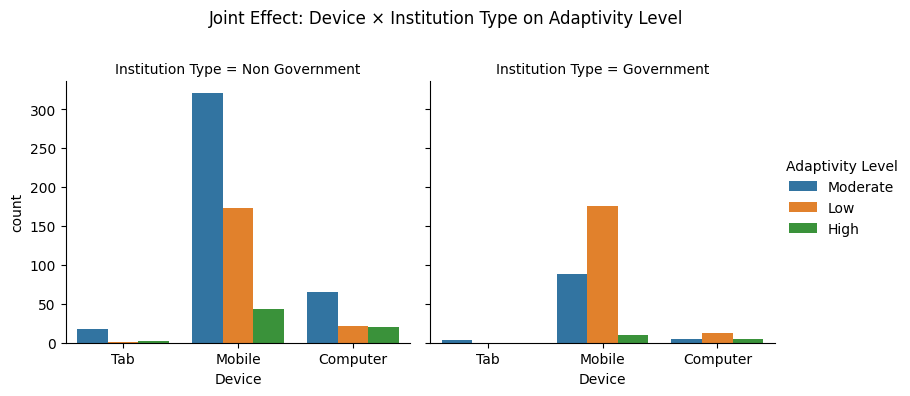

In [15]:
from scipy.stats import chi2_contingency, f_oneway, kruskal 
import itertools


# 2️⃣ Univariate Association with Target
print("=== Feature Associations with Target (Adaptivity Level) ===\n")

target = 'Adaptivity Level'
categorical_features = [col for col in decoded_df.columns if col != target]

for col in categorical_features:
    plt.figure(figsize=(5,3))
    sns.countplot(data=decoded_df, x=col, hue=target)
    plt.title(f"{col} vs {target}")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    # Chi-square test
    contingency = pd.crosstab(decoded_df[col], decoded_df[target])
    chi2, p, dof, _ = chi2_contingency(contingency)
    print(f"Chi-square test for {col} vs {target}: p-value = {p:.4f}")
    if p < 0.05:
        print("➡ Significant association (p < 0.05)")
    else:
        print("No significant association (p ≥ 0.05)")
    print()

# 3️⃣ Correlation Heatmap (Cramér’s V)
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramers_results = pd.DataFrame(index=categorical_features, columns=categorical_features)

for c1, c2 in itertools.combinations(categorical_features, 2):
    val = cramers_v(decoded_df[c1], decoded_df[c2])
    cramers_results.loc[c1, c2] = val
    cramers_results.loc[c2, c1] = val

np.fill_diagonal(cramers_results.values.astype(float), 1.0)

plt.figure(figsize=(10, 8))
sns.heatmap(cramers_results.astype(float), cmap="coolwarm", annot=True)
plt.title("Cramér’s V Correlation Heatmap (Categorical Features)")
plt.show()

# 4️⃣ Pairwise Relationships
print("=== Pairwise Feature Relationships (Chi-square Tests) ===\n")
for f1, f2 in itertools.combinations(categorical_features, 2):
    contingency = pd.crosstab(decoded_df[f1], decoded_df[f2])
    chi2, p, dof, _ = chi2_contingency(contingency)
    if p < 0.05:
        print(f"{f1} ↔ {f2} : Significant association (p={p:.4f})")

# 5️⃣ Joint Effects Visualization
joint_pairs = [
    ('Age', 'Education Level'),
    ('Financial Condition', 'Internet Type'),
    ('Device', 'Institution Type')
]

for f1, f2 in joint_pairs:
    g = sns.catplot(
        data=decoded_df,
        x=f1, hue='Adaptivity Level', col=f2,
        kind='count', height=4, aspect=1
    )
    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle(f"Joint Effect: {f1} × {f2} on Adaptivity Level")
    plt.show()



=== Class Distribution After SMOTE ===
Adaptivity Level
Moderate    500
Low         500
High        500
Name: count, dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_25204\1052166597.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_train_res_readable, palette="cool")


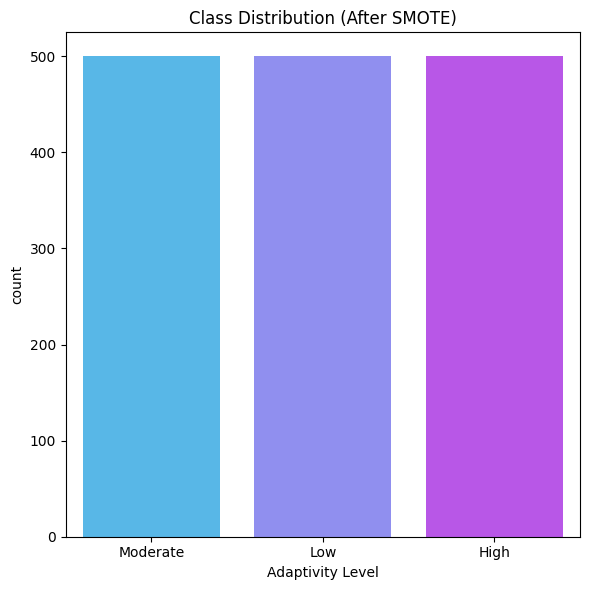

✅ Class distribution after SMOTE saved as 'adaptivity_plots\class_distribution_after_smote.png'



In [16]:
# ==============================================================
# 8️⃣ Apply SMOTE after EDA (Training Data Only) — show & save
# ==============================================================
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# decode resampled target for plotting (map numbers to labels)
y_train_res_readable = pd.Series(y_train_resampled).map({i: label for i, label in enumerate(adaptivity_labels)})

print("=== Class Distribution After SMOTE ===")
print(y_train_res_readable.value_counts())

plt.figure(figsize=(6, 6))
ax = sns.countplot(x=y_train_res_readable, palette="cool")
plt.title("Class Distribution (After SMOTE)")
plt.xlabel("Adaptivity Level")
plt.tight_layout()
fname = os.path.join(output_dir, "class_distribution_after_smote.png")
plt.savefig(fname, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

print(f"✅ Class distribution after SMOTE saved as '{fname}'\n")



In [17]:
# ==============================================================
# 9️⃣ Ready for Model Fitting
# ==============================================================
print(f"Training features: {X_train_resampled.shape}")
print(f"Testing features:  {X_test.shape}")
print("✅ Data ready for modeling after SMOTE.")

Training features: (1500, 13)
Testing features:  (241, 13)
✅ Data ready for modeling after SMOTE.
